In [ ]:
!pip install h5py
!pip install tensorflow

In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from scipy.stats.stats import mode
import seaborn as sns
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


# Statistic libraries
from scipy.optimize import fmin, minimize_scalar
from scipy import stats

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
from keras.models import load_model
from os import makedirs

In [ ]:
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib, DeepLearningExplore

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']

Mounted at /content/drive


In [ ]:
# Visualising info
df.head()

,band_1,band_2,is_iceberg
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0


In [ ]:
df_full.head()

,id,band_1,band_2,inc_angle,is_iceberg,max_b1,min_b1,delta_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,delta_b2,median_b2,mean_b2,argmax_b2,argmin_b2,delta_max,band_2ab,band_a2b
530,f06ecb96,"[[-22.622971, -19.042347, -18.257372, -18.6973...","[[-23.36264, -22.62306, -23.962086, -24.38596,...",30.4878,1,-0.897075,-29.583092,28.686017,-18.048462,-18.112508,2667,4169,-14.703813,-31.325020,16.621207,-22.802425,-22.830266,2741,4083,28.686017,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3..."
1140,974931df,"[[-27.235119, -26.907366, -24.170664, -24.1707...","[[-32.01276, -29.514042, -26.907423, -29.09036...",38.4591,1,-5.598961,-36.454388,30.855427,-26.289146,-26.294448,2888,4634,-23.071953,-38.634918,15.562965,-29.091711,-29.087352,51,1090,30.855427,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0...."
168,d6566373,"[[-28.63821, -26.238758, -29.042387, -29.04244...","[[-25.944237, -25.659485, -28.252216, -31.4044...",39.5048,0,-8.369424,-39.927570,31.558146,-27.886208,-28.104746,3124,4853,-17.648048,-39.926807,22.278759,-28.255713,-28.530522,3198,1629,31.558146,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0...."
135,6706ea46,"[[-22.52327, -20.36145, -18.631905, -19.001574...","[[-26.236002, -27.819691, -25.408276, -25.1489...",36.1091,1,-6.444110,-31.174166,24.730056,-19.936411,-20.070621,2732,2541,-18.755909,-36.697906,17.941997,-26.532661,-26.580998,2205,899,24.730056,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0...."
438,b792a605,"[[-19.505417, -21.23266, -28.363649, -29.63707...","[[-28.36356, -32.289497, -32.289543, -28.76776...",42.4126,0,8.382858,-31.131157,39.514015,-20.250298,-19.967787,3187,258,-2.915977,-39.649490,36.733513,-27.980453,-27.961630,3187,2931,39.514015,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0...."


In [ ]:
# Train/test split for the whole project as we don't have a test dataset
df_train = df.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [ ]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_2"]]
    )

train_cnn = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)
target_cnn=df_train['is_iceberg']

In [ ]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(train_cnn, target_cnn, random_state=42, train_size=0.7)

# Testing different models

In [ ]:
covnet = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn, batch_s = 20)
cv_1 = covnet.create_model(1, 2, drop_cv2D=True, normalization= True)

Epoch 1/150
36/36 [==============================] - ETA: 0s - loss: 0.6981 - binary_accuracy: 0.6045
Epoch 00001: val_binary_accuracy improved from -inf to 0.51948, saving model to best_weights_cv_1_2D_2_dense_.hdf5
36/36 [==============================] - 15s 41ms/step - loss: 0.6981 - binary_accuracy: 0.6045 - val_loss: 0.6957 - val_binary_accuracy: 0.5195
Epoch 2/150
34/36 [===========================>..] - ETA: 0s - loss: 0.6535 - binary_accuracy: 0.6221
Epoch 00002: val_binary_accuracy did not improve from 0.51948
36/36 [==============================] - 1s 22ms/step - loss: 0.6477 - binary_accuracy: 0.6281 - val_loss: 0.7161 - val_binary_accuracy: 0.4675
Epoch 3/150
34/36 [===========================>..] - ETA: 0s - loss: 0.6076 - binary_accuracy: 0.6574
Epoch 00003: val_binary_accuracy did not improve from 0.51948
36/36 [==============================] - 1s 23ms/step - loss: 0.6194 - binary_accuracy: 0.6476 - val_loss: 0.7362 - val_binary_accuracy: 0.4675
Epoch 4/150
34/36 [===

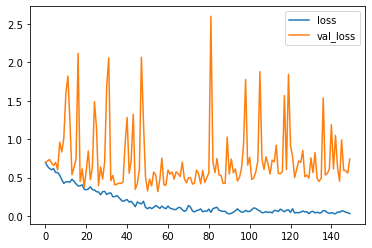

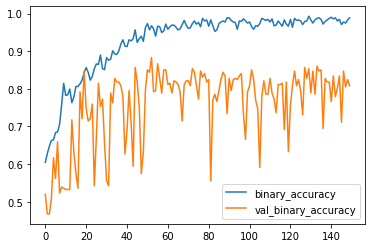

In [ ]:
covnet.get_best_trained(cv_1, 150, name="cv_1_2D_2_dense", verbose = True)

In [ ]:
tf.keras.utils.plot_model(cv_1)
cv_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 75, 75, 2)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                    

Epoch 1/150
36/36 [==============================] - ETA: 0s - loss: 0.7807 - binary_accuracy: 0.5864
Epoch 00001: val_binary_accuracy improved from -inf to 0.46753, saving model to best_weights_cv_2_2D_3_dense_.hdf5
36/36 [==============================] - 4s 41ms/step - loss: 0.7807 - binary_accuracy: 0.5864 - val_loss: 0.6962 - val_binary_accuracy: 0.4675
Epoch 2/150
34/36 [===========================>..] - ETA: 0s - loss: 0.7127 - binary_accuracy: 0.6103
Epoch 00002: val_binary_accuracy improved from 0.46753 to 0.53571, saving model to best_weights_cv_2_2D_3_dense_.hdf5
36/36 [==============================] - 1s 30ms/step - loss: 0.7204 - binary_accuracy: 0.6058 - val_loss: 0.6890 - val_binary_accuracy: 0.5357
Epoch 3/150
35/36 [============================>.] - ETA: 0s - loss: 0.6773 - binary_accuracy: 0.6029
Epoch 00003: val_binary_accuracy improved from 0.53571 to 0.60714, saving model to best_weights_cv_2_2D_3_dense_.hdf5
36/36 [==============================] - 1s 29ms/step -

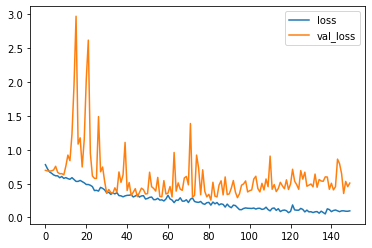

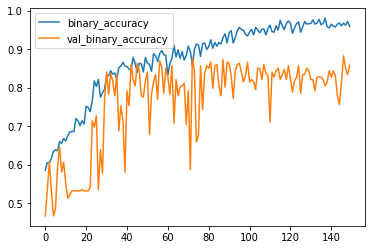

In [ ]:
cv_2 = covnet.create_model(2, 3, drop_cv2D= True, normalization = True)
covnet.get_best_trained(cv_2, 150, name="cv_2_2D_3_dense", verbose = True)

In [ ]:
cv_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                  

Epoch 1/150
36/36 [==============================] - ETA: 0s - loss: 0.7603 - binary_accuracy: 0.5557
Epoch 00001: val_binary_accuracy improved from -inf to 0.46753, saving model to best_weights_cv_4_2D_2_dense_.hdf5
36/36 [==============================] - 4s 43ms/step - loss: 0.7603 - binary_accuracy: 0.5557 - val_loss: 0.7177 - val_binary_accuracy: 0.4675
Epoch 2/150
35/36 [============================>.] - ETA: 0s - loss: 0.7433 - binary_accuracy: 0.5814
Epoch 00002: val_binary_accuracy did not improve from 0.46753
36/36 [==============================] - 1s 26ms/step - loss: 0.7408 - binary_accuracy: 0.5822 - val_loss: 0.7231 - val_binary_accuracy: 0.4675
Epoch 3/150
36/36 [==============================] - ETA: 0s - loss: 0.7088 - binary_accuracy: 0.6003
Epoch 00003: val_binary_accuracy did not improve from 0.46753
36/36 [==============================] - 1s 27ms/step - loss: 0.7088 - binary_accuracy: 0.6003 - val_loss: 0.7566 - val_binary_accuracy: 0.4675
Epoch 4/150
35/36 [====

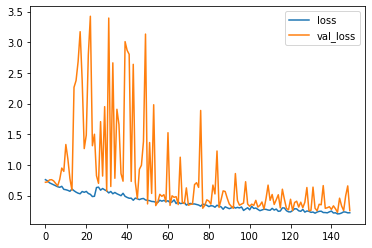

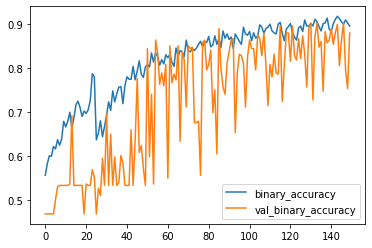

In [ ]:
cv_3 = covnet.create_model(4, 2, drop_cv2D= True, normalization = True)
covnet.get_best_trained(cv_3, 150, name="cv_4_2D_2_dense", verbose = True)

>>>>>>>>>>> fit no : 0 done
>>>>>>>>>>> fit no : 1 done
>>>>>>>>>>> fit no : 2 done
>>>>>>>>>>> fit no : 3 done
>>>>>>>>>>> fit no : 4 done
>>>>>>>>>>> fit no : 5 done
>>>>>>>>>>> fit no : 6 done
>>>>>>>>>>> fit no : 7 done
>>>>>>>>>>> fit no : 8 done
>>>>>>>>>>> fit no : 9 done
>>>>>>>>>>> fit no : 10 done
>>>>>>>>>>> fit no : 11 done
>>>>>>>>>>> fit no : 12 done
>>>>>>>>>>> fit no : 13 done
>>>>>>>>>>> fit no : 14 done
>>>>>>>>>>> fit no : 15 done
>>>>>>>>>>> fit no : 16 done
>>>>>>>>>>> fit no : 17 done
>>>>>>>>>>> fit no : 18 done
>>>>>>>>>>> fit no : 19 done
>>>>>>>>>>> fit no : 20 done
>>>>>>>>>>> fit no : 21 done
>>>>>>>>>>> fit no : 22 done
>>>>>>>>>>> fit no : 23 done
>>>>>>>>>>> fit no : 24 done
>>>>>>>>>>> fit no : 25 done
>>>>>>>>>>> fit no : 26 done
>>>>>>>>>>> fit no : 27 done
>>>>>>>>>>> fit no : 28 done
>>>>>>>>>>> fit no : 29 done
>>>>>>>>>>> fit no : 30 done
>>>>>>>>>>> fit no : 31 done
>>>>>>>>>>> fit no : 32 done
>>>>>>>>>>> fit no : 33 done
>>>>>>>>>>> fit no : 34 

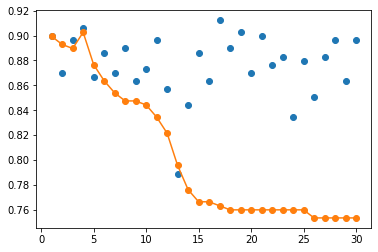

In [ ]:
covnet.horizontal_voting(n_epoch=150, n_save_after=120)

# Transfer learning

In [25]:
train_resnet50 = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)

In [26]:
from sklearn.model_selection import train_test_split

X_train_res50, X_valid_res50, y_train_res50, y_valid_res50 = train_test_split(train_resnet50, target_cnn, random_state=42, train_size=0.68)

In [27]:
res50 = DeepLearningExplore(df, X_train_res50, X_valid_res50, y_train_res50, y_valid_res50, batch_s = 20)
res50_model = res50.transferred_learning()

In [29]:
history_res50 = res50_model.fit(
      X_train_res50,
      y_train_res50,
      validation_data=(X_valid_res50, y_valid_res50),
      batch_size = 20,
      epochs = 100,
    )

Epoch 1/100
35/35 [==============================] - 3s 72ms/step - loss: 0.8114 - binary_accuracy: 0.5151 - val_loss: 0.6638 - val_binary_accuracy: 0.5258
Epoch 2/100
35/35 [==============================] - 2s 68ms/step - loss: 0.7286 - binary_accuracy: 0.5093 - val_loss: 0.6991 - val_binary_accuracy: 0.5593
Epoch 3/100
35/35 [==============================] - 3s 86ms/step - loss: 0.6452 - binary_accuracy: 0.6169 - val_loss: 0.6560 - val_binary_accuracy: 0.6748
Epoch 4/100
35/35 [==============================] - 2s 68ms/step - loss: 0.6475 - binary_accuracy: 0.6284 - val_loss: 0.6661 - val_binary_accuracy: 0.5228
Epoch 5/100
35/35 [==============================] - 2s 69ms/step - loss: 0.6813 - binary_accuracy: 0.6069 - val_loss: 0.6353 - val_binary_accuracy: 0.6383
Epoch 6/100
35/35 [==============================] - 2s 68ms/step - loss: 0.6244 - binary_accuracy: 0.6399 - val_loss: 0.6318 - val_binary_accuracy: 0.6261
Epoch 7/100
35/35 [==============================] - 3s 73ms/ste

Minimum Validation Loss: 0.5184
Maximum Validation Accuracy: 0.7477


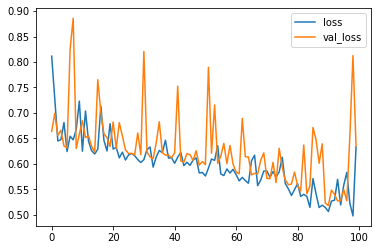

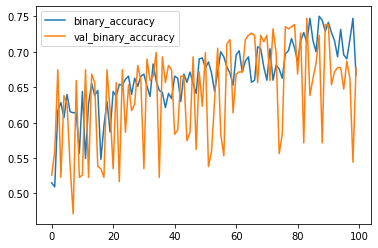

In [32]:
history_df = pd.DataFrame(history_res50.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_binary_accuracy'].max()))